In [372]:
import os
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [373]:
from collections import defaultdict
from flow_wmd.documents import Document
from flow_wmd.gale_shapeley import Matcher
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany, WMDPairs
from flow_wmd.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from random import shuffle
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import umap
import umap.plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [374]:
%%time

PATH = "../data/yelp_dataset/"
yelp_data = []
r_dtypes = {"review_id":str,
            "user_id":str,
            "business_id":str,
            "stars": np.int32, 
            "date":str,
            "text":str,
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32}
drop = ['review_id', 'user_id', 'useful', 'funny', 'cool']
query = "date >= '2017-12-01' and (stars==1 or stars ==5)"

with open(f"{PATH}yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, dtype=r_dtypes, chunksize=1000)
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=drop).query(query)
        yelp_data.append(reduced_chunk)
    
yelp_data = pd.concat(yelp_data, ignore_index=True)


CPU times: user 3min 6s, sys: 47.2 s, total: 3min 53s
Wall time: 5min 24s


In [941]:
yelp_data.shape

(1948607, 4)

In [942]:
yelp_business = pd.read_json(f"{PATH}yelp_academic_dataset_business.json", orient="records", lines=True)
yelp_business.shape

(160585, 14)

In [377]:
yelp_business = yelp_business[yelp_business.city.isin(["Portland", "Atlanta"])]
yelp_business.shape

(30815, 14)

In [378]:
yelp_merged = yelp_data.merge(yelp_business, on='business_id')

In [379]:
yelp_merged.shape

(451826, 17)

In [380]:
yelp_merged = yelp_merged.rename(columns={"stars_x":"stars"})

In [381]:
s_size = 250
rs = 42
sample = yelp_merged.groupby(["city", "stars"]).sample(n=s_size, random_state=rs).reset_index()
sample.shape

(2000, 18)

In [382]:
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [383]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [384]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['text']]

CPU times: user 794 ms, sys: 27.8 ms, total: 821 ms
Wall time: 864 ms


Denoise, remove special characters, lemmatize.

In [385]:
%%time

sample['review_clean']=sample['review_clean'].apply(denoise_text)
sample['review_clean']=sample['review_clean'].apply(remove_special_characters)
sample['review_clean']=sample['review_clean'].apply(simple_lemmatizer)

CPU times: user 626 ms, sys: 110 ms, total: 737 ms
Wall time: 870 ms


Remove stopwords again, after other preprocessing.

In [386]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['review_clean']]

CPU times: user 535 ms, sys: 15 ms, total: 550 ms
Wall time: 681 ms


Find phrases.

In [387]:
PHRASING = True
MIN = 500
THRESHOLD = 200

In [388]:
%%time

if PHRASING:
    sample['review_clean']= get_phrases([tokenizer.tokenize(i) for i in sample['review_clean']],
                                        min_count = MIN, 
                                        threshold = THRESHOLD)

CPU times: user 1.66 s, sys: 41.7 ms, total: 1.71 s
Wall time: 1.78 s


Data _before_ preprocessing and phrasing.

In [428]:
sample['text'][6]

'Most unprofessional restaurant manager I\'ve ever dealt with.\n\nI ordered a large veggie quesadilla (12$) and my friend got a small chicken quesadilla (6.50$). Upon arrival we realize they are the same size, but mine is cut. \n\nI brought this to Jazzy, our server, attention and showed her and she was like yea thats not right. I am happy to pay the 6.50$ for the size of quesadilla I received. \n\nThe manager, Rosa, comes to the table and explains that I got a large, it is made with two tortillas. I show her the fold of  single tortilla. Then she says well actually its one 12" tortilla and my friends was a 10". I tell her there is no way mine could have been 12" it is the same diameter as my friends. \nShe continues that it is large because it has "more stuffing". I ask her to bring me a tortilla. She brings both sizes and insists I got a large and says i am paying full price or 2$ off. I insist I\'m paying menu price for what I received. (6.5$).\nShe storms off. I take my slice of qu

Data _after_ preprocessing and phrasing.

In [425]:
#sample['review_clean'][0]
" ".join(sample['review_clean'][6])

'unprofessional restaurant manager ever dealt ordered large veggie quesadilla friend got small chicken quesadilla upon arrival realize size mine cut brought jazzy server attention showed like yea thats right happy pay size quesadilla received manager rosa come table explains got large made two tortilla show fold single tortilla say well actually one tortilla friend tell way mine could diameter friend continues large stuffing ask bring tortilla brings size insists got large say paying full price insist paying menu price received storm take slice quesadilla hold smaller tortilla size without hesitation touch food bare hand begin dig inside state dont touch food took price quesadilla told banned coming_back since unable admit kitchen mistake made charge accordingly justified mistake changing criterion large small time touched patron food bare handed bad eating anymore jazzy awesome guacamole'

In [400]:
sample["sentiment"] = ['positive' if s == 5 else 'negative' for s in sample['stars']]

In [401]:
sample[["sentiment", "stars"]]

,sentiment,stars
0,negative,1
1,negative,1
2,negative,1
3,negative,1
4,negative,1
...,...,...
1995,positive,5
1996,positive,5
1997,positive,5
1998,positive,5


In [673]:
sample.head()

,level_0,index,business_id,stars,text,date,name,address,city,state,...,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,0,240568,X3uNEXlRhtKnArhxSGrBIQ,1,Going through the drive through wasn't bad but...,2018-01-27 16:37:31,Einstein Bros Bagels,"1100 Hammond Dr Ne, Ste 600",Atlanta,GA,...,33.919266,-84.351989,2.5,154,1,"{'BusinessParking': '{'garage': False, 'street...","Bagels, Food, Restaurants, Breakfast & Brunch","{'Monday': '5:0-17:0', 'Tuesday': '5:0-17:0', ...","[going, drive, bad, wait, item, took, little, ...",negative
1155,1155,237865,CoZbETgq7mF5JzzxLMeF6Q,1,I never thought I'd be one to give pizza anyth...,2020-10-09 04:09:17,Via Chicago,2013 NE Alberta Ave,Portland,OR,...,45.559203,-122.644492,4.0,308,1,"{'RestaurantsGoodForGroups': 'True', 'BikePark...","Restaurants, Pizza, Food Stands","{'Monday': '11:0-22:0', 'Tuesday': '11:0-23:0'...","[never, thought, one, give, pizza, anything, l...",negative
1156,1156,88041,ufnpH_JO9QJKeDf7g7Y9oA,1,I'm 63 and normally don't write reviews becaus...,2018-07-28 20:58:58,Quest Diagnostics,13485 Nw Cornell Rd,Portland,OR,...,45.527992,-122.814475,2.5,6,1,None,"Laboratory Testing, Diagnostic Services, Healt...","{'Monday': '13:0-16:30', 'Tuesday': '13:0-16:3...","[normally, write_review, business_owner, lot, ...",negative
1157,1157,280702,xeFke1EuoYXOZaX1rTQYEw,1,Such a disappointment! Went at noon on a Frida...,2018-07-13 21:01:30,Thai Champa,938 E Burnside St,Portland,OR,...,45.522733,-122.656442,4.5,325,1,"{'Alcohol': ''none'', 'HappyHour': 'False', 'H...","Restaurants, Food Trucks, Laotian, Thai, Food","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...","[disappointment, went, noon, friday, guess, lu...",negative
1158,1158,132920,GMar8UtettoKJ6FZgG1gDg,1,I am thinking about refinancing only to rid my...,2020-05-29 16:09:43,Gregory Funding Llc,425 NW 10th Ave Ste 307,Portland,OR,...,45.526141,-122.681258,1.5,7,0,None,"Home Services, Real Estate, Mortgage Brokers",None,"[thinking, refinancing, rid, new, loan, servic...",negative


In [674]:
sample.columns

Index(['level_0', 'index', 'business_id', 'stars', 'text', 'date', 'name',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars_y', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'review_clean', 'sentiment'],
      dtype='object')

In [683]:
sample = sample.sort_values("sentiment").drop('level_0', axis=1).reset_index()

### 1.3 Separate pos and neg reviews

In [687]:
pos = sample[sample.sentiment == "positive"].reset_index(drop=True)
neg = sample[sample.sentiment == "negative"].reset_index(drop=True)

In [688]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [689]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:2000]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:2000]))

In [690]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

In [691]:
print(len(pos_sample))
print(len(neg_sample))

1000
1000


### 2.2 Load pretrained Google News W2V model

In [416]:
finetuned = True

In [420]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using Yelp review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/yelp_w2v.txt', binary=False)

Loading GoogleNews Vectors
CPU times: user 48.8 s, sys: 3.89 s, total: 52.7 s
Wall time: 55.7 s


In [421]:
model.distance("taco", "burrito")

0.26227182149887085

In [426]:
model.distance("quesadilla","tostada")

0.3457874059677124

In [427]:
model.distance("sushi", "sashimi")

0.24882382154464722

### 2.3 Load corpus and remove OOV words

In [692]:
%%time

corpus = pos_sample + neg_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/Users/mikaelbrunila/Documents/Code/flow-wmd/venv-fwmd/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 737 ms, sys: 40.2 ms, total: 777 ms
Wall time: 841 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff7cafd1dc0>,
                use_idf=False)

In [693]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 25.3 ms, sys: 187 ms, total: 212 ms
Wall time: 452 ms


In [694]:
len(oov)

1273

In [695]:
print(oov[:50])

["'", ',', '[', ']', 'able_get', 'ablebodied', 'ableist', 'absolute_worst', 'absolutely_awful', 'absolutely_delicious', 'absolutely_horrible', 'absolutely_love', 'acknowledgement', 'across_street', 'acted_like', 'acura', 'adel', 'adobada', 'advantaclean', 'aetrex', 'africanamerican', 'aftergot', 'afuri', 'agedashi', 'agreedupon', 'ahc', 'ahead_time', 'ahmayzing', 'aida', 'aiden', 'aimee', 'airbnb', 'airflyer', 'aislebins', 'aknowledgemnt', 'aladdin', 'alamir_pdx', 'alana', 'alcia', 'aliera', 'allthey', 'alpharetta', 'alphonio', 'already_paid', 'altanera', 'alvarowas', 'amam', 'amana', 'amazing_job', 'americanized']


In [696]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:2000]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:2000]))

CPU times: user 885 ms, sys: 20.3 ms, total: 906 ms
Wall time: 973 ms
CPU times: user 1.39 s, sys: 33.6 ms, total: 1.42 s
Wall time: 1.49 s


In [697]:
pos_sample[5]

'food delicious outdoor_seating bit chilly wait pick'

In [698]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 30 µs
CPU times: user 215 ms, sys: 14.5 ms, total: 230 ms
Wall time: 249 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7ff7cafd1dc0>)

Bag-of-words vectorizer.

In [699]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [700]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:2000]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:2000]))

In [701]:
print(pos_tok[5][:20])

['food', 'delicious', 'outdoor_seating', 'bit', 'chilly', 'wait', 'pick']


In [702]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 12.3 ms, sys: 98 µs, total: 12.4 ms
Wall time: 12.4 ms


In [703]:
len(oov_)

0

### 2.4 Get features and embeddings

In [704]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [705]:
E = model[features]
#E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [585]:
#X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [586]:
%%time

K = range(10,210, 10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [587]:
%%time

wvec_ssd, wvec_silhouette = kmeans_search(E, K)

For n_clusters = 10 The average silhouette_score is : 0.0048870924
For n_clusters = 20 The average silhouette_score is : -0.0045487885
For n_clusters = 30 The average silhouette_score is : -0.013450309
For n_clusters = 40 The average silhouette_score is : -0.013978215
For n_clusters = 50 The average silhouette_score is : -0.028676057
For n_clusters = 60 The average silhouette_score is : -0.053541888
For n_clusters = 70 The average silhouette_score is : -0.035639092
For n_clusters = 80 The average silhouette_score is : -0.027800914
For n_clusters = 90 The average silhouette_score is : -0.034088783
For n_clusters = 100 The average silhouette_score is : -0.042346764
For n_clusters = 110 The average silhouette_score is : -0.041213974
For n_clusters = 120 The average silhouette_score is : -0.042985883
For n_clusters = 130 The average silhouette_score is : -0.0457045
For n_clusters = 140 The average silhouette_score is : -0.051638562
For n_clusters = 150 The average silhouette_score is : -0.

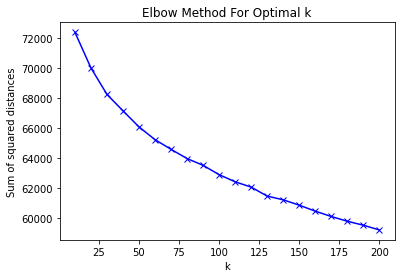

In [588]:
plot_kmeans(K,wvec_ssd,"elbow")

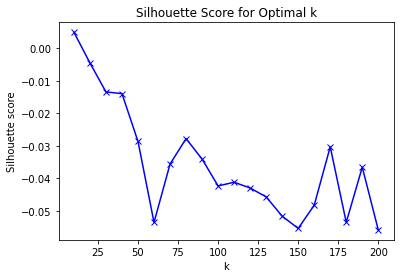

In [589]:
plot_kmeans(K,wvec_silhouette,"silhouette")

Assign labels and centroids to separate variables for later use.

#### 2.5.2 T-SNE + Kmeans

In [590]:
method='barnes_hut'
n_components = 2
verbose = 1

In [591]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9413 samples in 0.007s...
[t-SNE] Computed neighbors for 9413 samples in 2.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9413
[t-SNE] Computed conditional probabilities for sample 2000 / 9413
[t-SNE] Computed conditional probabilities for sample 3000 / 9413
[t-SNE] Computed conditional probabilities for sample 4000 / 9413
[t-SNE] Computed conditional probabilities for sample 5000 / 9413
[t-SNE] Computed conditional probabilities for sample 6000 / 9413
[t-SNE] Computed conditional probabilities for sample 7000 / 9413
[t-SNE] Computed conditional probabilities for sample 8000 / 9413
[t-SNE] Computed conditional probabilities for sample 9000 / 9413
[t-SNE] Computed conditional probabilities for sample 9413 / 9413
[t-SNE] Mean sigma: 0.684253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.945068
[t-SNE] KL divergence after 1000 iterations: 3.106699


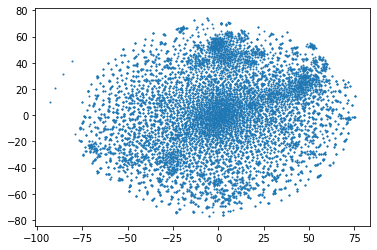

In [592]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

In [593]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 10 The average silhouette_score is : 0.34488717
For n_clusters = 20 The average silhouette_score is : 0.3372342
For n_clusters = 30 The average silhouette_score is : 0.3312462
For n_clusters = 40 The average silhouette_score is : 0.3336319
For n_clusters = 50 The average silhouette_score is : 0.33292577
For n_clusters = 60 The average silhouette_score is : 0.33240375
For n_clusters = 70 The average silhouette_score is : 0.33114016
For n_clusters = 80 The average silhouette_score is : 0.33670086
For n_clusters = 90 The average silhouette_score is : 0.33434618
For n_clusters = 100 The average silhouette_score is : 0.33501622
For n_clusters = 110 The average silhouette_score is : 0.332212
For n_clusters = 120 The average silhouette_score is : 0.33530146
For n_clusters = 130 The average silhouette_score is : 0.33940127
For n_clusters = 140 The average silhouette_score is : 0.33824897
For n_clusters = 150 The average silhouette_score is : 0.33759972
For n_clusters = 160 The

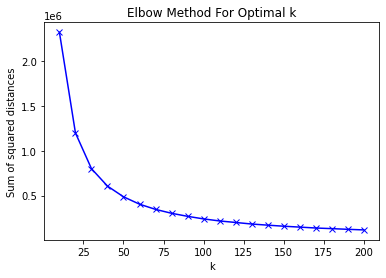

In [594]:
plot_kmeans(K,tsne_ssd,"elbow")

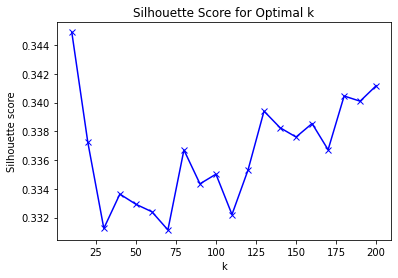

In [595]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.3 PCA + Kmeans

In [596]:
n_components = 0.9
verbose = 1

In [597]:
pca_fit = PCA(n_components = n_components).fit(E)

In [598]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

223
[0.0425863  0.02936171 0.02077154 0.01640652 0.01537853 0.01520989
 0.01391615 0.01250578 0.01124508 0.01088646 0.01039432 0.00969045
 0.00926796 0.00876875 0.00834858 0.00826789 0.00789331 0.00761299
 0.00753696 0.00723431 0.00717772 0.00703408 0.00677471 0.00664112
 0.00656772 0.00641005 0.00634135 0.00622863 0.00610965 0.00597832
 0.00592486 0.00576861 0.00567186 0.00558054 0.00550333 0.00536556
 0.00527132 0.00519128 0.0051543  0.00504555 0.00502225 0.00496014
 0.00492316 0.00486792 0.00483825 0.00476409 0.00470758 0.00465494
 0.00458735 0.00455864 0.00450269 0.0044208  0.00440022 0.00437838
 0.00431066 0.00424952 0.00423462 0.00421048 0.00414769 0.00406015
 0.00405572 0.00404131 0.00397421 0.00395434 0.00390802 0.00386373
 0.00383442 0.00379924 0.00379052 0.00377549 0.00373654 0.00368607
 0.00366969 0.00362445 0.00357398 0.00355799 0.00353417 0.00350639
 0.00347852 0.00346484 0.0034269  0.00339724 0.00338981 0.00336939
 0.00336473 0.00334317 0.00331275 0.00328065 0.00327175 0.

In [599]:
E_pca = pca_fit.transform(E)

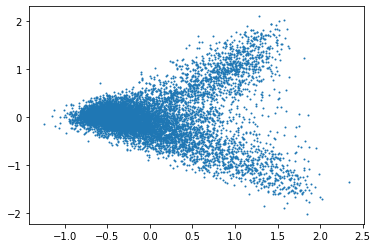

In [600]:
plt.scatter(E_pca[:, 0], E_pca[:, 1], s=1);

In [601]:
%%time

pca_ssd, pca_silhouette = kmeans_search(E_pca, K)

For n_clusters = 10 The average silhouette_score is : 0.012352858
For n_clusters = 20 The average silhouette_score is : 0.0058038337
For n_clusters = 30 The average silhouette_score is : -0.003994512
For n_clusters = 40 The average silhouette_score is : -0.021709612
For n_clusters = 50 The average silhouette_score is : -0.008725485
For n_clusters = 60 The average silhouette_score is : -0.04823015
For n_clusters = 70 The average silhouette_score is : -0.022156313
For n_clusters = 80 The average silhouette_score is : -0.049250927
For n_clusters = 90 The average silhouette_score is : -0.021058626
For n_clusters = 100 The average silhouette_score is : -0.011208477
For n_clusters = 110 The average silhouette_score is : -0.024578236
For n_clusters = 120 The average silhouette_score is : -0.044699457
For n_clusters = 130 The average silhouette_score is : -0.037258327
For n_clusters = 140 The average silhouette_score is : -0.032816883
For n_clusters = 150 The average silhouette_score is : -0.0

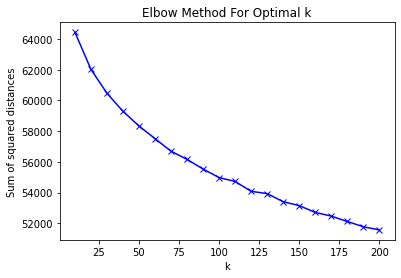

In [602]:
plot_kmeans(K,pca_ssd,"elbow")

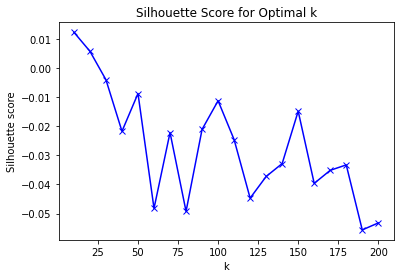

In [603]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### 2.5.4 UMAP + Kmeans

In [604]:
%%time

metric = 'cosine'
dm = cdist(E, E, metric)
np.fill_diagonal(dm, 0)

CPU times: user 29.3 s, sys: 450 ms, total: 29.7 s
Wall time: 30.1 s


In [605]:
is_valid_dm(dm)

True

In [606]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.9248557342994198 0.08732844843311895


In [607]:
min_dist=mean - 5*std
n_neighbors = int(0.001*len(E))
n_components=2
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.4882134921338251
N. neighbors: 9
N. compontents: 2


In [608]:
%%time

E_umap = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=verbose
).fit_transform(E)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.4882134921338251, n_neighbors=9,
     random_state=42, verbose=1)
Construct fuzzy simplicial set
Mon Jul 26 15:10:55 2021 Finding Nearest Neighbors
Mon Jul 26 15:10:55 2021 Building RP forest with 10 trees
Mon Jul 26 15:10:56 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	Stopping threshold met -- exiting after 7 iterations
Mon Jul 26 15:10:57 2021 Finished Nearest Neighbor Search
Mon Jul 26 15:10:57 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jul 26 15:11:22 2021 Finished embedding
CPU times: user 15 s, sys: 5.55 s, total: 20.5 s
Wall time: 26.7 s


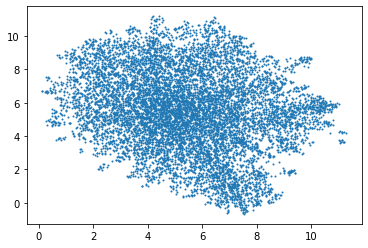

In [609]:
plt.scatter(E_umap[:, 0], E_umap[:, 1], s=1);

In [610]:
%%time

umap_ssd, umap_silhouette = kmeans_search(E_umap, K)

For n_clusters = 10 The average silhouette_score is : 0.34773073
For n_clusters = 20 The average silhouette_score is : 0.33901826
For n_clusters = 30 The average silhouette_score is : 0.33505654
For n_clusters = 40 The average silhouette_score is : 0.33489707
For n_clusters = 50 The average silhouette_score is : 0.33510685
For n_clusters = 60 The average silhouette_score is : 0.3385732
For n_clusters = 70 The average silhouette_score is : 0.33857962
For n_clusters = 80 The average silhouette_score is : 0.34351763
For n_clusters = 90 The average silhouette_score is : 0.34230384
For n_clusters = 100 The average silhouette_score is : 0.33888248
For n_clusters = 110 The average silhouette_score is : 0.34269255
For n_clusters = 120 The average silhouette_score is : 0.33791223
For n_clusters = 130 The average silhouette_score is : 0.3402726
For n_clusters = 140 The average silhouette_score is : 0.34286374
For n_clusters = 150 The average silhouette_score is : 0.34359643
For n_clusters = 160 

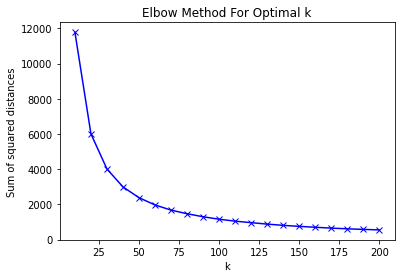

In [611]:
plot_kmeans(K,umap_ssd,"elbow")

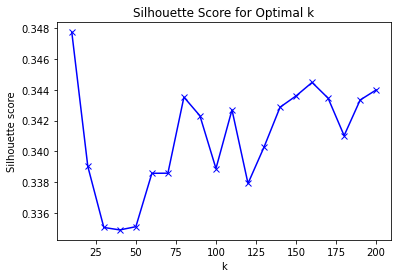

In [612]:
plot_kmeans(K,umap_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [706]:
k = 100

In [707]:
%%time

km_base = cluster.KMeans(n_clusters=k,max_iter=300).fit(E)
labels = km_base.labels_
centroids = km_base.cluster_centers_

km_pca = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_pca)
labels_pca = km_pca.labels_

km_umap = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_umap)
labels_umap=km_umap.labels_

km_tsne = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_tsne)
labels_tsne = km_tsne.labels_

CPU times: user 2min, sys: 16.5 s, total: 2min 16s
Wall time: 30.3 s


Create an index that maps each word to a cluster.

In [708]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [709]:
print(take(10, word2cluster.items()))

[('_', 92), ('aa', 20), ('aaa', 96), ('aaargh', 20), ('aardvark', 18), ('aaron', 43), ('aban', 20), ('abatement', 23), ('abby', 96), ('abe', 20)]


Now, conversely, create an index that maps each cluster to a word.

In [710]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [711]:
print(len(cluster2words[0]))
print(cluster2words[0][:100])

169
['accepting', 'accumulating', 'acting', 'adapting', 'addressing', 'adhering', 'adjusting', 'amassing', 'answering', 'applying', 'appreciating', 'articulating', 'assuming', 'assuring', 'avoiding', 'balancing', 'battling', 'becoming', 'bettering', 'blending', 'blocking', 'bringing', 'canceling', 'carrying', 'cashing', 'changing', 'charging', 'checking', 'choosing', 'clarifying', 'committing', 'completing', 'considering', 'consolidating', 'continuing', 'controlling', 'counting', 'covering', 'creating', 'customizing', 'cutting', 'dealing', 'debating', 'deciphering', 'delivering', 'destroying', 'determining', 'disconnecting', 'discovering', 'discussing', 'disguising', 'distancing', 'drawing', 'encouraging', 'enforcing', 'enhancing', 'ensuring', 'entering', 'exchanging', 'exposing', 'extending', 'fighting', 'figuring', 'finding', 'fixing', 'focusing', 'forgetting', 'forming', 'fulfilling', 'gaining', 'getting', 'giving', 'guarding', 'handling', 'holding', 'hosting', 'hurting', 'ignoring'

In [712]:
print(len(cluster2words[1]))
print(cluster2words[1][:100])

191
['absorbed', 'accepted', 'accommodated', 'acquired', 'acted', 'adapted', 'addressed', 'adhered', 'administered', 'advertised', 'altered', 'answered', 'applied', 'appointed', 'approved', 'arranged', 'assisted', 'audited', 'available', 'backed', 'billed', 'boxed', 'built', 'carried', 'certified', 'challenged', 'changed', 'checked', 'cleared', 'closed', 'commenced', 'communicated', 'complemented', 'completed', 'conducted', 'considered', 'constructed', 'contained', 'contracted', 'controlled', 'converted', 'corrected', 'counted', 'covered', 'crafted', 'created', 'dated', 'dealt', 'deemed', 'delivered', 'designated', 'developed', 'directed', 'discontinued', 'discovered', 'displayed', 'distanced', 'distributed', 'documented', 'done', 'drawn', 'embraced', 'employed', 'enforced', 'entered', 'executed', 'extracted', 'fashioned', 'featured', 'filled', 'flagged', 'folded', 'forgotten', 'formed', 'forsaken', 'forwarded', 'found', 'frequented', 'handled', 'held', 'identified', 'inspected', 'inst

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [713]:
pos_nbow[0]

<1x9413 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [944]:
random.seed(42)
random.shuffle([1,2,3])

In [714]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E))

CPU times: user 395 ms, sys: 150 ms, total: 545 ms
Wall time: 696 ms


In [715]:
pos_docs[0].nbow

array([[0., 0., 0., ..., 0., 0., 0.]])

In [716]:
pos_docs[0].weights_sum

0.9999999999999998

In [717]:
pos_docs[0].idxs[:10]

[259, 8071, 5512, 8330, 2582, 3607, 6043, 9118, 8484, 2349]

In [718]:
pos_docs[0].vecs[:1][0][:10]

array([ 0.07373047,  0.00405884, -0.13574219,  0.02209473,  0.18066406,
       -0.04663086,  0.22460938, -0.22949219, -0.04003906,  0.22558594],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [719]:
lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)

In [720]:
%time lc_rwmd.get_D()
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 3min 43s, sys: 53.5 s, total: 4min 36s
Wall time: 1min 19s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [975]:
# Options: 'gale_shapeley','random','full'

pairing = 'full'

In [994]:
%%time

if pairing == 'gale_shapeley':
    print("Running Gale-Shapeley pairing.")
    matcher = Matcher(lc_rwmd.D)
    engaged = matcher.matchmaker()
    matcher.check()
    pairs = engaged
if pairing == 'random':
    print("Running random pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    shuffle(pos_idx)
    shuffle(neg_idx)
    pairs = dict(zip(pos_idx, neg_idx))
if pairing == 'full':
    print("Running full pairing.")
    idx = list(range(0,len(pos_docs)*len(neg_docs)))
    #neg_idx = list(range(0,len(neg_docs)))
    pairs = dict([(i,j) for i, j in enumerate(idx)])
    pos_docs = [d for d in pos_docs for _ in list(range(0,len(neg_docs)))]
    neg_docs = [d for d in neg_docs for _ in list(range(0,len(pos_docs)))]

Running full pairing.
CPU times: user 205 ms, sys: 72.5 ms, total: 277 ms
Wall time: 279 ms


Let's look at the output of Gale-Shapeley:

In [899]:
take(10, pairs.items())

[(125, 835),
 (278, 884),
 (821, 765),
 (42, 722),
 (719, 759),
 (769, 656),
 (299, 974),
 (91, 416),
 (306, 732),
 (910, 694)]

In [900]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in take(10, pairs.items())]

In [901]:
example_pairs[9][0]

'found place yelp event block warm portland beautiful fall day decided visit first customer day kinda stalked place opened portland full ice_cream shop kinda known ice_cream donut picky ice_cream want give something buy store especially scoop want something weird sake weird scoop amazing flavor tried two knew wanted mocha almond fudge counter know front best ice_cream ever delicious strong boy got pumpkin one tried bite like eating pumpkin pie super amazing also service awesome sweet counter even engaged boy midday school homeschool went school online high school really appreciate people judge wonderful'

In [902]:
example_pairs[9][1]

'tiny burger even fill bun pathetic salad bar pathetic size food pathetic asian buffet understand place empty turkey place packed come ever patty size slider patty'

In [903]:
len(pairs)

1000

### 2.9 Pairwise WMD with Baseline Kmeans

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [ ]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs.get_distances(thread=False)

The return value is a matrix of distances between the document pairs.

In [515]:
wmd_pairs.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [904]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
Calculated distances between approximately 500 documents.
Calculated distances between approximately 600 documents.
Calculated distances between approximately 700 documents.
Calculated distances between approximately 800 documents.
Calculated distances between approximately 900 documents.
CPU times: user 55.2 s, sys: 9.37 s, total: 1min 4s
Wall time: 21.6 s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [905]:
wmd_pairs_flow.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [906]:
take(10, wmd_pairs_flow.wc_X1.items())

[('lightbulb', 0.06372),
 ('modification', 0.07730999999999999),
 ('idea', 1.20872),
 ('cancer', 0.23643999999999998),
 ('bumper', 0.16123),
 ('coffee_shop', 1.5934),
 ('typical', 0.44619),
 ('dahl', 0.15775),
 ('readily', 0.08899),
 ('kill', 0.25777)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [907]:
take(10, wmd_pairs_flow.wc_X2.items())

[('pitch', 0.10343),
 ('disarray', 0.21404),
 ('idea', 1.3298899999999998),
 ('farming', 0.15733),
 ('disciplined', 0.0572),
 ('cancer', 0.03389),
 ('bumper', 0.04991),
 ('dazzling', 0.023950000000000003),
 ('coffee_shop', 0.40754),
 ('errant', 0.15336)]

In [908]:
take(10, wmd_pairs_flow.cc_X1.items())

[(92, 117.83205000000002),
 (20, 42.91567000000002),
 (96, 46.17776999999999),
 (18, 21.504310000000007),
 (43, 35.81591000000001),
 (23, 18.014640000000004),
 (98, 48.03902000000006),
 (6, 38.18080000000005),
 (51, 6.473539999999999),
 (33, 27.837000000000003)]

In [909]:
take(10, wmd_pairs_flow.cc_X2.items())

[(92, 119.18460000000017),
 (20, 28.565939999999998),
 (96, 35.79141000000001),
 (18, 13.122179999999993),
 (43, 16.387919999999994),
 (23, 29.60128000000002),
 (98, 72.84340000000002),
 (6, 39.74502999999998),
 (51, 36.989119999999986),
 (33, 43.29742000000003)]

In [910]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{48: 197.26184000000072,
 5: 157.95753999999994,
 80: 147.62368999999998,
 73: 129.13356000000007,
 50: 118.21009000000022,
 92: 117.83205000000002,
 94: 86.45355000000005,
 76: 73.32366999999999,
 36: 72.35494,
 64: 64.44206999999999}

In [911]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [974]:
top_words_x1 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x1_df = pd.DataFrame.from_dict(top_words_x1, orient='index', columns = ["cost"])
top_words_x1_df

,cost
great,11.85737
amazing,9.44487
delicious,8.00963
best,7.55645
definitely,7.23168
love,6.79777
friendly,6.71801
favorite,5.85835
nice,5.63774
food,5.21703


Next, let's see what added most distance when moving from the negative to the positive reviews.

In [969]:
top_words_x2 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x2_df = pd.DataFrame.from_dict(top_words_x2, orient='index', columns = ["cost"])
top_words_x2_df

,cost
rude,10.95100
order,9.68584
told,9.08055
never,7.56445
worst,7.42532
minute,7.23739
asked,6.67519
hour,6.59229
horrible,6.40268
min,6.38389


Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [914]:
n_clusters = 10
n_words = 10

In [915]:
c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [916]:
c1

,48,5,80,73,50,92,94,76,36,64
0,great (27.53),always (6.54),place (7.75),delicious (18.22),pizza (3.76),variety (2.75),wait (4.24),love (13.42),service (5.75),donut (3.38)
1,amazing (22.95),definitely (5.89),spot (7.69),food (14.93),dish (3.61),different (2.52),disappoint (2.12),thank (7.2),staff (4.49),biscuit (3.11)
2,best (11.43),everything (4.93),team (3.17),tasty (5.4),burger (3.0),new (2.41),die (1.94),loved (6.26),environment (3.82),bowl (3.03)
3,excellent (9.74),especially (2.62),weekend (1.37),menu (4.92),chicken (2.65),also (2.37),jam (1.2),welcoming (4.34),experience (2.97),egg (1.69)
4,awesome (8.89),little (2.28),beat (1.22),vegan (4.38),fried_chicken (2.61),hand (1.91),chop (1.08),enjoyed (4.1),work (1.67),baked (1.55)
5,nice (8.55),really (2.28),winner (1.05),yummy (4.14),chicken_sandwich (2.47),many (1.61),miss (0.91),glad (2.59),partner (0.71),cake (1.37)
6,good (8.39),everyone (1.93),anniversary (1.03),meal (3.91),bread (2.44),seasonal (1.56),poke (0.9),happy (2.34),inspection (0.69),collard_green (1.26)
7,favorite (7.47),much (1.54),pairing (1.03),chef (3.14),sandwich (2.41),portion (1.5),sit (0.84),enjoy (1.99),expert (0.59),pie (1.0)
8,perfect (6.2),lot (1.51),event (0.99),outdoor_seating (3.11),steak (2.31),beyond (1.36),flare (0.76),excited (1.45),dean (0.57),yum (1.0)
9,fantastic (5.84),bit (1.4),class (0.98),restaurant (2.5),pork (2.26),future (1.06),chase (0.73),thanks (1.24),master (0.41),brownie (0.99)


Negative to positive clusters.

In [917]:
c2 

,5,80,92,94,52,36,26,8,98,60
0,never (7.56),one (3.82),without (2.2),get (5.53),asked (6.68),manager (5.71),left (3.39),response (2.45),give (3.58),review (2.56)
1,still (3.81),close (2.45),instead (1.91),drive (2.91),waited (4.32),management (2.91),sat (2.6),answer (2.33),take (2.46),charge (2.5)
2,even (3.42),line (2.37),elsewhere (1.88),suck (2.79),would (3.79),corporate (1.19),went (2.19),item (2.24),avoid (1.89),appointment (2.42)
3,nothing (3.21),another (2.27),number (1.79),tip (2.67),please (3.57),associate (1.17),walked (2.13),picture (2.12),cancel (1.84),delivery (2.36)
4,way (2.56),run (1.95),least (1.71),move (2.12),ordered (3.33),member (1.04),threw (2.06),piece (2.11),use (1.79),sign (2.29)
5,someone (2.56),two (1.93),however (1.35),lie (1.36),waiting (2.87),training (1.0),took (2.0),account (1.77),help (1.76),bill (1.97)
6,anything (2.08),half (1.73),apparently (1.27),put (1.35),asking (2.6),support (0.97),sucked (1.79),reason (1.5),stay (1.16),claim (1.84)
7,like (2.06),front (1.62),already (1.27),stick (1.04),want (2.46),system (0.94),drove (1.71),issue (1.21),save (1.1),open (1.63)
8,going (1.84),past (1.38),complete (1.22),pick (0.99),refused (2.3),tech (0.92),gone (1.49),word (1.19),change (0.93),card (1.44)
9,mean (1.8),host (1.32),rather (0.93),fly (0.98),wanted (2.29),maintenance (0.87),broken (1.36),act (1.15),send (0.92),package (1.33)


In [918]:
x1_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x1_costs.index = list(pairs.keys())
x1_costs = x1_costs.sort_index()
x1_costs = x1_costs[c1.columns]
x1_costs['city'] = sample[:1000].city

In [919]:
Counter(x1_costs.city)

Counter({'Atlanta': 500, 'Portland': 500})

In [920]:
x1_costs_long = pd.melt(x1_costs, id_vars=['city']).rename(columns={"variable":"cluster"})
x1_costs_long.head()

,city,cluster,value
0,Atlanta,48,0.14563
1,Atlanta,48,0.16863
2,Atlanta,48,0.08212
3,Atlanta,48,0.06176
4,Atlanta,48,0.08473


In [921]:
x1_costs_long = x1_costs_long[x1_costs_long.value != 0]

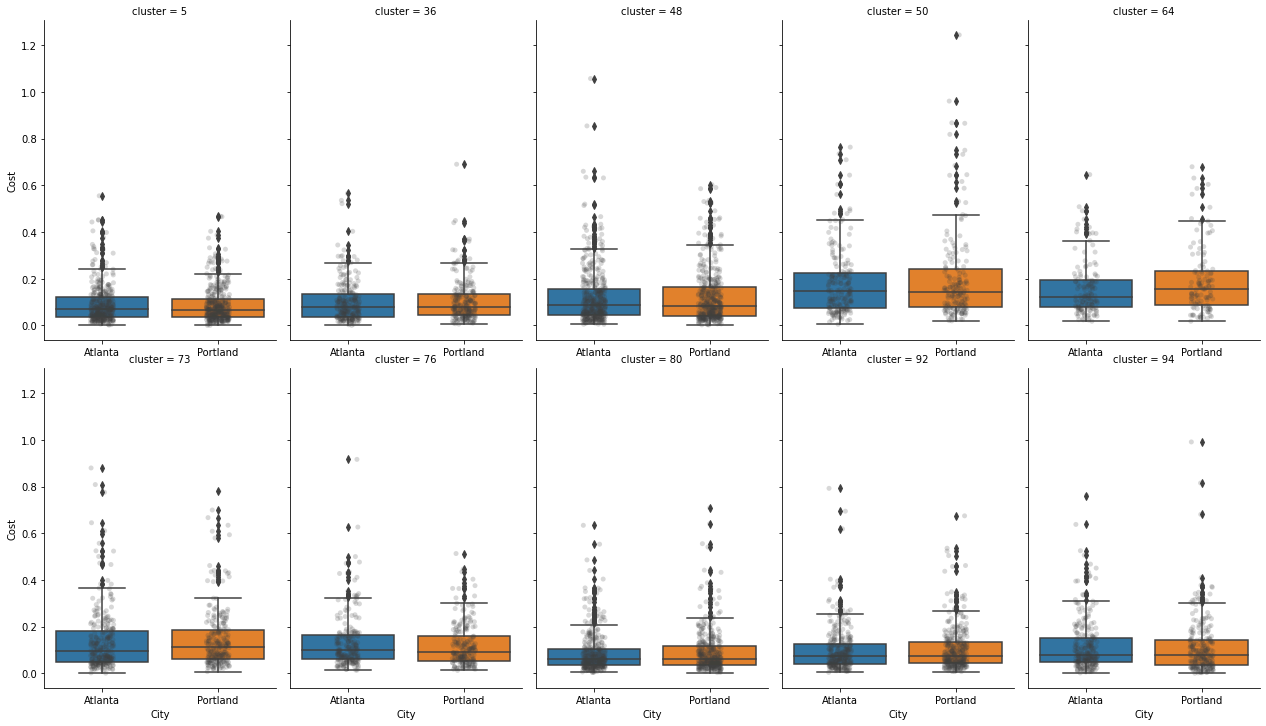

In [922]:
g = sns.catplot(x="city", 
                y="value", 
                col="cluster", 
                data=x1_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="city", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("City", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


In [923]:
x2_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x2_costs.index = list(pairs.values())
x2_costs = x2_costs.sort_index()
x2_costs = x2_costs[c2.columns]
x2_costs['city'] = sample[1000:2000].city.tolist()

In [924]:
x2_costs_long = pd.melt(x2_costs, id_vars=['city']).rename(columns={"variable":"cluster"})
x2_costs_long.head()

,city,cluster,value
0,Atlanta,5,0.07283
1,Atlanta,5,0.06773
2,Atlanta,5,0.11964
3,Atlanta,5,0.23837
4,Atlanta,5,0.03491


In [925]:
x2_costs_long = x2_costs_long[x2_costs_long.value != 0]

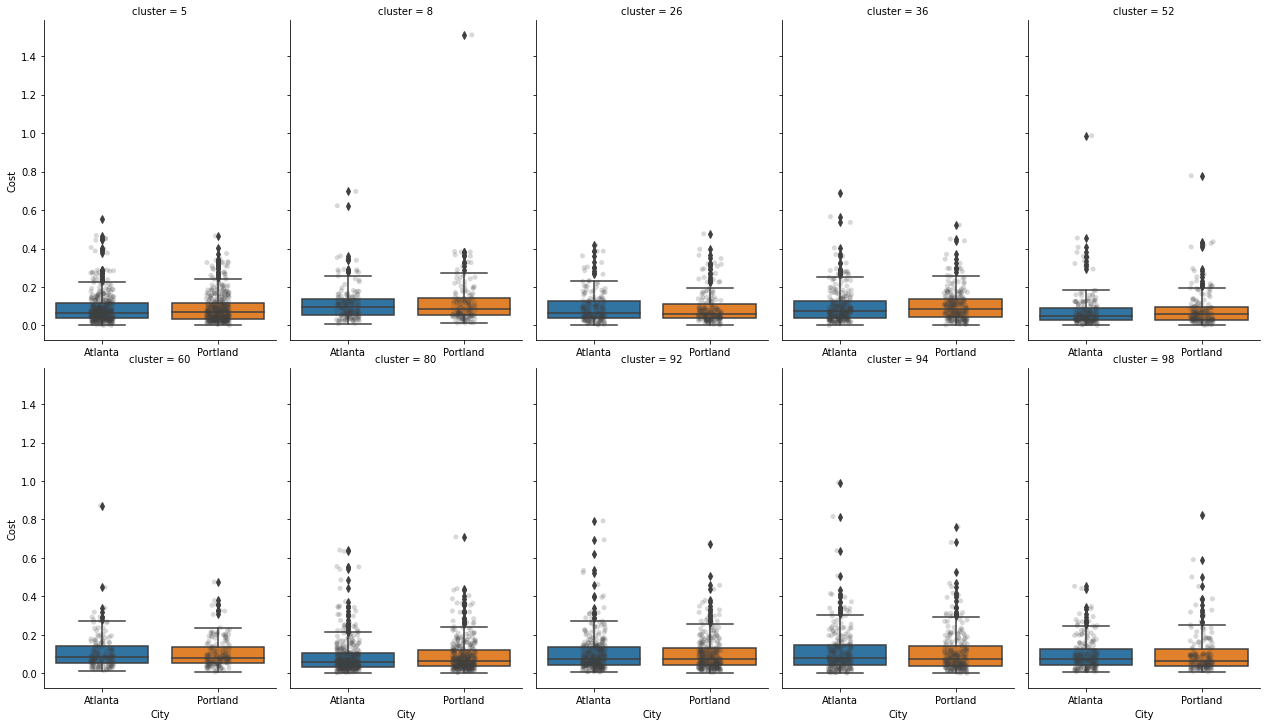

In [926]:
g = sns.catplot(x="city", 
                y="value", 
                col="cluster", 
                data=x2_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="city", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("City", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


## 4 Better clusters with UMAP and T-SNE

#### 4.1 UMAP + Kmeans

In [118]:
word2cluster_u = {features[idx]: cl for idx, cl in enumerate(labels_umap)}

In [119]:
print(take(10, word2cluster_u.items()))

[(']', 84), ('^_', 49), ('`', 4), ('aaargh', 3), ('aaliyah', 8), ('aamir_khan', 54), ('aaron', 13), ('aaron_eckhart', 18), ('ab_tak', 93), ('abandon', 92)]


Now, conversely, create an index that maps each cluster to a word.

In [120]:
cluster2words_u = defaultdict(list)
for key, value in word2cluster_u.items():
    cluster2words_u[value].append(key)

In [121]:
%%time 

wmd_pairs_flow_u = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_u.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 3s, sys: 15.9 s, total: 2min 19s
Wall time: 1min 13s


In [123]:
wmd_pairs_flow_u.get_differences()

In [125]:
c1_u = output_clusters(wc=wmd_pairs_flow_u.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X1.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_u = output_clusters(wc=wmd_pairs_flow_u.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X2.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [126]:
c1_u

,38,65,48,50,6,45,78,16,14,68
0,great (2.48),loved (1.27),game (1.77),dvd (0.7),still (1.8),year (0.8),film (0.68),little (1.23),performance (1.36),story (0.7)
1,best (2.03),enjoy (0.72),hard (0.42),show (0.4),disney (0.89),new (0.67),although (0.37),entertaining (0.66),role (0.9),quality (0.3)
2,excellent (1.42),well_worth (0.67),cartoon (0.18),hope (0.39),every (0.34),night (0.43),cinema (0.36),hilarious (0.5),star (0.55),quite (0.3)
3,wonderful (1.3),want (0.42),people (0.16),channel (0.37),compared (0.19),day (0.39),hollywood (0.22),comedy (0.43),play (0.46),edge_seat (0.23)
4,song (0.96),check (0.25),segal (0.15),found (0.34),taste (0.19),old (0.38),though (0.18),plus (0.32),playing (0.39),build (0.23)
5,brilliant (0.83),liked (0.23),meatball (0.14),buy (0.33),much (0.16),lived (0.35),throughout (0.17),fulci (0.3),great_job (0.31),clever (0.23)
6,perfect (0.75),enjoyed (0.21),animated (0.14),glad (0.31),one (0.15),late (0.33),filled (0.17),humor (0.28),hamlet (0.2),bit (0.23)
7,beautiful (0.68),would_recommend (0.19),subtitle (0.14),film_festival (0.27),sf (0.14),memory (0.29),pure (0.14),martial_art (0.26),davy (0.19),romantic_comedy (0.22)
8,soundtrack (0.67),seen (0.17),serial (0.13),first_saw (0.25),eighty (0.14),grew (0.25),part (0.12),enjoyable (0.23),rest_cast (0.18),extremely (0.19)
9,amazing (0.65),thought (0.17),exactly (0.13),video (0.25),perhaps (0.13),last (0.25),dated (0.11),humour (0.21),supporting_cast (0.18),suspenseful (0.13)


In [127]:
c2_u

,65,48,56,6,30,16,63,50,78,77
0,movie (2.33),would (0.5),bad (5.31),even (1.48),worst (2.48),stupid (1.61),better (1.0),came (0.35),director (0.41),supposed (0.74)
1,really (0.94),reason (0.47),plot (1.52),could (1.22),ever_seen (0.95),funny (0.87),least (0.77),fox (0.31),effort (0.34),case (0.52)
2,rating (0.84),going (0.46),boring (1.38),instead (1.03),one_worst (0.88),joke (0.76),nothing (0.76),sat (0.31),seems (0.27),making (0.43)
3,say (0.72),gave (0.42),awful (1.34),made (0.83),ever (0.74),idiotic (0.39),ok (0.63),episode (0.31),numerous (0.27),understand (0.39)
4,rent (0.7),basically (0.42),terrible (1.24),enough (0.72),hour (0.74),unrealistic (0.37),cheap (0.6),finished (0.28),point (0.27),obviously (0.36)
5,maybe (0.61),never (0.4),poor (1.12),idea (0.59),minute (0.72),lot (0.37),anything (0.56),picked (0.27),contain (0.19),project (0.27)
6,anyone (0.61),wrong (0.4),horrible (0.93),either (0.46),worse (0.72),overall (0.32),sequel (0.43),series (0.25),example (0.18),sort (0.26)
7,watching (0.52),happen (0.39),script (0.7),rest (0.45),something (0.68),nudity (0.29),whole_thing (0.42),blockbuster (0.25),almost (0.15),fact (0.26)
8,review (0.52),tried (0.37),dialog (0.63),make_sense (0.45),waste (0.65),serious (0.28),b (0.41),rented (0.21),shocking (0.15),blame (0.25)
9,recommend (0.48),like (0.37),dull (0.6),producer (0.36),waste_time (0.61),disgusting (0.28),expect (0.39),went_see (0.21),columbo (0.14),confused (0.25)


#### 4.1 T-SNE + Kmeans

In [128]:
word2cluster_t = {features[idx]: cl for idx, cl in enumerate(labels_tsne)}

In [129]:
print(take(10, word2cluster_t.items()))

[(']', 65), ('^_', 25), ('`', 45), ('aaargh', 79), ('aaliyah', 39), ('aamir_khan', 56), ('aaron', 84), ('aaron_eckhart', 20), ('ab_tak', 54), ('abandon', 74)]


Now, conversely, create an index that maps each cluster to a word.

In [139]:
cluster2words_t = defaultdict(list)
for key, value in word2cluster_t.items():
    cluster2words_t[value].append(key)

In [141]:
%%time 

wmd_pairs_flow_t = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_t.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_t, 
                               c2w = cluster2words_t,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 5s, sys: 14.9 s, total: 2min 20s
Wall time: 1min 16s


In [142]:
wmd_pairs_flow_t.get_differences()

In [143]:
c1_t = output_clusters(wc=wmd_pairs_flow_t.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X1.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_t = output_clusters(wc=wmd_pairs_flow_t.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X2.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [144]:
c1_t

,92,67,86,48,99,87,10,31,17,95
0,loved (1.27),great (2.48),disney (0.89),thought (0.17),game (1.77),performance (1.36),dvd (0.7),real (0.65),feeling (0.6),year (0.8)
1,time (0.84),excellent (1.42),film (0.68),people (0.16),hilarious (0.5),role (0.9),hope (0.39),often (0.4),feel (0.54),night (0.43)
2,well_worth (0.67),wonderful (1.3),entertaining (0.66),exactly (0.13),comedy (0.43),star (0.55),channel (0.37),moving (0.35),message (0.43),day (0.39)
3,fan (0.55),song (0.96),definitely (0.54),folk (0.12),scifi (0.43),play (0.46),found (0.34),filmed (0.21),reality (0.34),lived (0.35)
4,wish (0.28),brilliant (0.83),special (0.39),shocked (0.11),show (0.4),playing (0.39),buy (0.33),top (0.17),theme (0.3),memory (0.29)
5,liked (0.23),perfect (0.75),cinema (0.36),happy_ending (0.11),humor (0.28),great_job (0.31),glad (0.31),main (0.15),issue (0.21),future (0.26)
6,enjoyed (0.21),beautiful (0.68),particularly (0.35),wanting (0.09),short (0.24),usual (0.25),film_festival (0.27),character (0.15),society (0.18),grew (0.25)
7,seen (0.17),soundtrack (0.67),classic (0.33),figured (0.08),clever (0.23),rest_cast (0.18),first_saw (0.25),segment (0.13),importance (0.17),last (0.25)
8,buy_copy (0.16),amazing (0.65),work (0.33),running_time (0.08),humour (0.21),supporting_cast (0.18),video (0.25),sequence (0.13),complex (0.16),took (0.22)
9,really_liked (0.16),incredible (0.59),highly_recommend (0.28),cared (0.08),one_liner (0.17),shine (0.17),theater (0.21),edited (0.11),dealing (0.16),weekend (0.21)


In [145]:
c2_t

,28,92,48,89,49,19,31,42,82,86
0,bad (5.31),movie (2.33),hour (0.74),worst (2.48),even (1.48),really (0.94),shot (0.67),could (1.22),made (0.83),better (1.0)
1,stupid (1.61),rating (0.84),minute (0.72),ever_seen (0.95),enough (0.72),maybe (0.61),scene (0.54),instead (1.03),supposed (0.74),original (0.33)
2,plot (1.52),say (0.72),anyone (0.61),one_worst (0.88),idea (0.59),mean (0.42),camera (0.51),least (0.77),making (0.43),overall (0.32)
3,boring (1.38),watching (0.52),bored (0.58),ever (0.74),premise (0.45),guess (0.38),numerous (0.27),nothing (0.76),wrong (0.4),serious (0.28)
4,awful (1.34),review (0.52),end (0.5),rent (0.7),disappointing (0.36),like (0.37),main_character (0.27),anything (0.56),line (0.27),produced (0.14)
5,terrible (1.24),reason (0.47),depressing (0.49),something (0.68),producer (0.36),someone (0.35),echo (0.19),either (0.46),meant (0.17),standard (0.08)
6,poor (1.12),disappointed (0.34),actually (0.47),waste (0.65),unfortunately (0.35),seriously (0.32),example (0.18),gave (0.42),looking (0.17),bollywood (0.08)
7,horrible (0.93),comment (0.34),going (0.46),waste_time (0.61),stereotype (0.29),anymore (0.26),relentlessly (0.17),laugh (0.34),ruin (0.15),worked (0.07)
8,worse (0.72),saying (0.33),make_sense (0.45),ever_made (0.56),seems (0.27),hate (0.24),clip (0.16),cool (0.32),appeal (0.13),equally (0.07)
9,dialog (0.63),hated (0.32),seemed (0.45),recommend (0.48),project (0.27),hell (0.24),particular (0.16),seagal (0.29),describe (0.12),dubbed (0.07)


## 5 Reduced Dimension Inputs

### 5.1 UMAP

In [ ]:
### TODO: lcwmd with UMAP

In [170]:
%%time 

wmd_pairs_flow_uvecs = WMDPairs(pos_docs,neg_docs,pairs,E_umap,idx2word)
wmd_pairs_flow_uvecs.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 1min 34s, sys: 4.71 s, total: 1min 39s
Wall time: 1min 30s


### 5.2 T-SNE

## 6 Statistical Models

In [234]:
import statsmodels.api as sm

In [317]:
np.max(wmd_pairs_flow.X1_feat)

0.39088

In [276]:
feats = np.copy(wmd_pairs_flow.X1_feat)

In [277]:
feats[feats>0] = 1
feats

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [258]:
np.sum(feats[0,])

39.0

In [279]:
ols = sm.OLS(np.sum(wmd_pairs_flow.X1_feat, axis=1), feats)
res = ols.fit()

In [289]:
params = list(np.round(res.params, 3))

In [309]:
params.index(sorted(params)[-97])

15

In [311]:
params[97]

0.003

In [318]:
print(cluster2words[97])

['addressed', 'allowed', 'apparent', 'avoids', 'breakdown', 'carefully', 'central', 'central_character', 'change', 'changing', 'choosing', 'chosen', 'claustrophobia', 'clear', 'close', 'closest', 'coincidence', 'comedy_tragedy', 'common', 'complicated', 'concentrate', 'concerned', 'concerning', 'conflict', 'connect', 'connected', 'connecting', 'connection', 'consequently', 'construct', 'contempt', 'continuing', 'conviction', 'dealt', 'despicable', 'despite_fact', 'detached', 'develop', 'developed', 'developing', 'development', 'develops', 'device', 'dignity', 'disparate', 'dominate', 'dramatically', 'drawn', 'eliminated', 'encountered', 'establish', 'established', 'establishing', 'event', 'event_unfold', 'evolve', 'evolves', 'explicitly', 'explored', 'fall_apart', 'feel_sympathy', 'fictional', 'focus', 'focused', 'focusing', 'follow', 'following', 'form', 'forward', 'foundation', 'framework', 'gap', 'general', 'glimpse', 'gradual', 'hint', 'hinted', 'hopeless', 'identified', 'ignoring'

## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}